In [1]:
%matplotlib inline
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt 
import os
import pydotplus

from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn import metrics 

from collections import defaultdict
from collections import Counter

from IPython.display import Image  

In [2]:
# Master dataframe containg all possible columns 
df_master = pd.read_pickle('master_location.pkl')
df_master = df_master.dropna()
df_master = df_master[df_master.longitude < -157.5]
df_master = df_master.groupby('area').filter(lambda x: len(x) >= 10)

In [3]:
# True classification of data points
df_truth = df_master['type'].astype('category').to_frame()
df_truth = df_truth.dropna()
df_truth['type_code'] = df_truth['type'].cat.codes
df_truth.head()

,type,type_code
4333,MOTOR VEHICLE COLLISION,1
4332,MOTOR VEHICLE COLLISION - TOWED,2
4331,MOTOR VEHICLE COLLISION,1
4330,MOTOR VEHICLE COLLISION,1
4329,TRAFFIC NUISANCE OR PARKING VIOLATION,5


In [4]:
# Frequency of incidents by area 
# df_master = df_master.groupby('area').filter(lambda x: len(x) >= 10)
# df_master.area.value_counts().plot.bar()

In [5]:
# df = pd.DataFrame()
# Categorizing streets with binary values
def street(d):
    if d['freeway'] == 0 and d['highway'] == 0:
        return 1 
    else:
        return 0
# Categorizing freeways, highways, and streets
df_master['freeway'] = np.where(df_master['address'].str.contains('FWY|H1|H2|H3')==True, 1,0)
df_master['highway'] = np.where(df_master['address'].str.contains('HWY')==True, 1,0)
df_master['street'] = df_master.apply(street,axis=1)

In [6]:
# Categorizing streets with strings 
def location(d):
    address = d['address']
    if 'FWY|H1|H2|H3' in address:
        return 'freeway'
    elif 'HWY' in address:
        return 'highway'
    else:
        return 'street'
df_master['road_type'] = df_master.apply(location, axis=1) 

In [7]:
# Categorizing accident types into binary values
type_dummies = pd.get_dummies(df_master['type'])
df_master = pd.concat([df_master,type_dummies], axis = 1)

In [8]:
# Categorizing accident areas into binary values
area_dummies = pd.get_dummies(df_master['area'])
df_master = pd.concat([df_master,area_dummies], axis = 1)

In [9]:
# Categorizing accident day of the week into binary values
dayofweek_dummies = pd.get_dummies(df_master['dayofweek_name'])
df_master = pd.concat([df_master, dayofweek_dummies], axis=1)

In [10]:
# Categorizing accident by hour of the day into binary values
hourofday_dummies = pd.get_dummies(df_master['hour'])
df_master = pd.concat([df_master, hourofday_dummies], axis=1)

In [11]:
# Categorizing weekday or weekend into binary values
weekend = ['Friday','Saturday','Sunday']
df_master['weekend'] = np.where(df_master['dayofweek_name'].isin(weekend), 1,  0)

In [12]:
# Categorizing hours of the day into strings
def timeofday(d):
    hour = d['hour']
    if hour >= 23 or hour < 5: return 'late night'
    elif hour >=5 and hour < 10: return 'morning'
    elif hour >=10 and hour < 15: return 'mid-day'
    elif hour >=15 and hour < 19: return 'dusk'
    elif hour >=19 and hour < 23: return 'night'
df_master['timeofday'] = df_master.apply(timeofday,axis=1)

In [13]:
# Categorizing times of the into binary values
timeofday_dummies = pd.get_dummies(df_master['timeofday'])
df_master = pd.concat([df_master, timeofday_dummies],axis=1)

# Clustering 

In [14]:
# Error of clusters
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')
    
# Adjusted Random Index Score
def ri_evaluate_clusters(X,max_clusters,ground_truth):
    ri = np.zeros(max_clusters+1)
    ri[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        ri[k] = metrics.adjusted_rand_score(kmeans.labels_,ground_truth)
    plt.plot(range(1,len(ri)),ri[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Adjusted Rand Index')

# Plotting clusters 
def graph(x, y, l, name):
    '''
    Referncing points by their index in a series
    x: pd.Series
    y: pd.Series
    label: pd.Series
    '''
    x_coord = real_longitude
    y_coord = real_latitude
    labels = l
    colors = ['orange', 'cyan', 'darkgreen', 'red', 'blue', 'yellow', 'purple', 'black','brown', 'olive', 'grey', 'pink']

    plt.figure(figsize=(12,10))
    for idx, label in labels.iteritems():
        plt.scatter(x_coord[idx], y_coord[idx], color = colors[label])
    plt.savefig('graphs/' + name + '.png')
    

# K-Means Clustering By Day of the Week and Location

In [15]:
# Clustering based only on collisions 
collisions = ['HAZARDOUS DRIVER', 'MOTOR VEHICLE COLLISION','MOTOR VEHICLE COLLISION - TOWED']
df_col = df_master.loc[df_master['type'].isin(collisions)]

In [16]:
# Create data frame for clustering by day of the week and longitude and latitude
columns = ['latitude','longitude']
columns += ['Monday','Tuesday','Wednesday','Thursday']
columns += ['Friday','Saturday','Sunday']
df_day = df_master[columns]
df_day = df_day.dropna()

# Normalize longitude and latitude 
scale = preprocessing.StandardScaler().fit(df_day[['longitude','latitude']])
df_std= scale.transform(df_day[['longitude','latitude']])
longitude, latitude = zip(*df_std)
df_day['norm_latitude'] = list(latitude)
df_day['norm_longitude'] = list(longitude)

# Actual latitude and longitude are kept for plotting purposes
real_longitude = df_day['longitude']
real_latitude = df_day['latitude']
df_day = df_day.drop(['latitude','longitude'],axis=1)
df_day.head()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,norm_latitude,norm_longitude
4333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.127076,0.454946
4332,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.793117,0.461611
4331,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.021062,0.903951
4330,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.098472,1.133842
4329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.524431,-0.957896


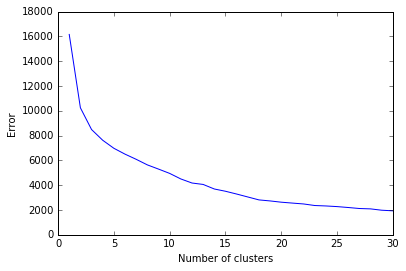

In [17]:
evaluate_clusters(df_day, 30)

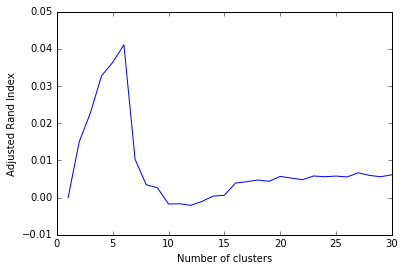

In [18]:
ri_evaluate_clusters(df_day, 30,df_truth['type_code'])

In [19]:
# K-means clusterings 
k = 6
kmeans = KMeans(n_clusters=k)
kmeans.fit_predict(df_day)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_
df_day['label'] = labels
df_day.head()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,norm_latitude,norm_longitude,label
4333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.127076,0.454946,0
4332,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.793117,0.461611,0
4331,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.021062,0.903951,0
4330,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.098472,1.133842,0
4329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.524431,-0.957896,4


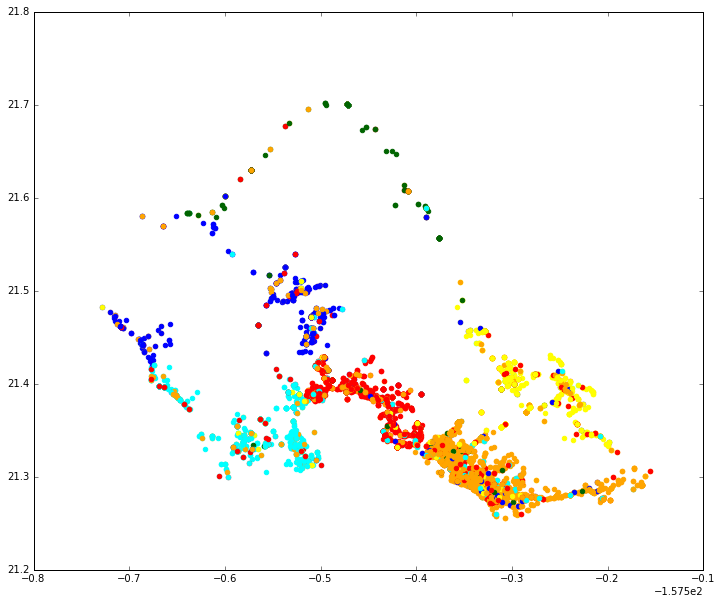

In [20]:
# Graphing clusters
graph(real_longitude, real_latitude, df_day['label'], 'cluster_dayofweek')

# K-Means Clustering By Hour of the Day and Location

In [21]:
# Create dataframe for clustering by hour of the day and location
columns = list(range(0,24)) +['latitude', 'longitude']
df_st = df_master[columns]
df_st= df_st.dropna()

# Standardizing longitude and latitude data
scale = preprocessing.StandardScaler().fit(df_st[['longitude','latitude']])
df_std = scale.transform(df_st[['longitude','latitude']])
longitude, latitude = zip(*df_std)
df_st['norm_latitude'] = list(latitude)
df_st['norm_longitude'] = list(longitude)

# Storing actual longitude and latitude data for plotting
real_longitude = df_st['longitude']
real_latitude = df_st['latitude']
df_st = df_st.drop(['latitude','longitude'],axis=1)
df_st.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,norm_latitude,norm_longitude
4333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.127076,0.454946
4332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.793117,0.461611
4331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.021062,0.903951
4330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.098472,1.133842
4329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.524431,-0.957896


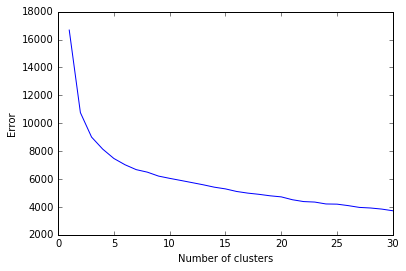

In [22]:
evaluate_clusters(df_st, 30)

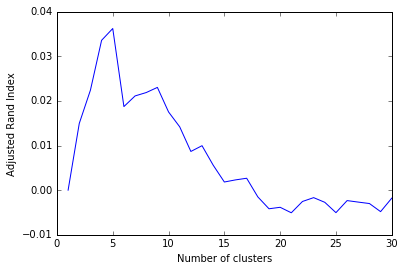

In [23]:
ri_evaluate_clusters(df_st, 30, df_truth['type_code'])

In [24]:
# K-means clustering 
k = 7
kmeans = KMeans(n_clusters=k)
kmeans.fit_predict(df_st)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_
df_st['label'] = labels
df_st.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,norm_latitude,norm_longitude,label
4333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.127076,0.454946,0
4332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.793117,0.461611,2
4331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.021062,0.903951,2
4330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.098472,1.133842,2
4329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.524431,-0.957896,1


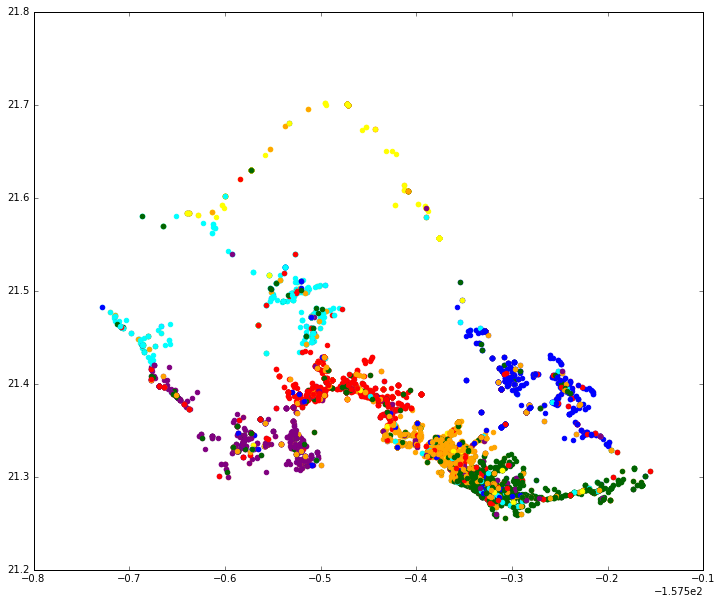

In [25]:
graph(real_longitude, real_latitude, df_st['label'],'clustering_hourofday ')

In [26]:
# Getting a sense of type of traffic incident associated with each cluster
temp = df_master.reset_index().drop_duplicates(subset='index',keep='last').set_index('index')
d = defaultdict(list)
for idx, row in df_st.iterrows():
    label = row['label']
    d[label].append(temp.loc[idx]['type'])
for label in d:
    freq = Counter(d[label])
    d[label] = freq 
d

defaultdict(list,
            {0.0: Counter({'HAZARDOUS DRIVER': 137,
                      'MOTOR VEHICLE COLLISION': 735,
                      'MOTOR VEHICLE COLLISION - TOWED': 13,
                      'STALLED/HAZARDOUS VEHICLE': 126,
                      'TRAFFIC INCIDENT - NO COLLISION': 20,
                      'TRAFFIC NUISANCE OR PARKING VIOLATION': 294,
                      'TRAFFIC SIGNAL PROBLEM': 46}),
             1.0: Counter({'HAZARDOUS DRIVER': 54,
                      'MOTOR VEHICLE COLLISION': 214,
                      'MOTOR VEHICLE COLLISION - TOWED': 6,
                      'STALLED/HAZARDOUS VEHICLE': 21,
                      'TRAFFIC INCIDENT - NO COLLISION': 6,
                      'TRAFFIC NUISANCE OR PARKING VIOLATION': 92,
                      'TRAFFIC SIGNAL PROBLEM': 4}),
             2.0: Counter({'HAZARDOUS DRIVER': 112,
                      'MOTOR VEHICLE COLLISION': 920,
                      'MOTOR VEHICLE COLLISION - TOWED': 23,
         

In [27]:
# Getting sense of hour of day of each cluster 
time = defaultdict(list)
for idx, row in df_st.iterrows():
    label = row['label']
    for col, val in row.iteritems():
        if val == 1 and str(col).isdigit():
            time[label].append(col)
            break;
for label in time:
    freq = Counter(time[label])
    time[label] = freq 
time

defaultdict(list,
            {0.0: Counter({0: 22,
                      1: 19,
                      2: 16,
                      3: 14,
                      4: 9,
                      5: 27,
                      6: 37,
                      7: 48,
                      8: 88,
                      9: 61,
                      10: 88,
                      11: 78,
                      12: 88,
                      13: 91,
                      14: 107,
                      15: 110,
                      16: 88,
                      17: 90,
                      18: 93,
                      19: 47,
                      20: 39,
                      21: 52,
                      22: 34,
                      23: 25}),
             1.0: Counter({0: 5,
                      1: 4,
                      2: 6,
                      3: 5,
                      4: 4,
                      5: 9,
                      6: 22,
                      7: 20,
                      8: 12,
    

# GMM Clustering By Day of the Week

In [28]:
gmm = GaussianMixture(n_components=5, covariance_type='diag')

In [29]:
temp = df_day[columns]
gmm.fit(temp)
y_pred = gmm.predict(temp)
df_day['label'] = y_pred
df_day.head()

KeyError: "[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 'latitude'\n 'longitude'] not in index"

In [ ]:
graph(real_longitude, real_latitude, df_day['label'])

In [ ]:
# Getting idea of clusters 
d = defaultdict(list)
columns = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for idx, row in df_day.iterrows():
    label = row['label']
    for col, val in row.iteritems():
        if val == 1 and col in columns:
            d[label].append(col)
            break;
for label in d:
    freq = Counter(d[label])
    d[label] = freq 
d

# GMM Clustering By Hour of the Day

In [ ]:
columns = list(range(0,24))
temp = df_st[columns]
gmm.fit(temp)
y_pred = gmm.predict(temp)
df_st['label'] = y_pred
df_st.head()

In [ ]:
graph(real_longitude, real_latitude, df_st['label'])

In [ ]:
d = defaultdict(list)
for idx, row in df_st.iterrows():
    label = row['label']
    for col, val in row.iteritems():
        if val == 1:
            d[label].append(col)
            break;
for label in d:
    freq = Counter(d[label])
    d[label] = freq 
d

# Decision Tree Modeling

In [ ]:
# Data frame used training decision tree 
df_X = df_master[['hour', 'longitude', 'latitude', 'AIEA', 'AINA HAINA', 'AIRPORT', 'ALA MOANA', 'ALIAMANU',
       'DOWNTOWN', 'EWA BEACH', 'HALEIWA', 'HAUULA', 'HAWAII KAI',
       'HONOLULU', 'KAHALA', 'KAHALUU', 'KAHUKU', 'KAILUA', 'KAIMUKI',
       'KAKAAKO', 'KALAELOA', 'KALIHI', 'KANEOHE', 'KAPAHULU', 'KAPOLEI',
       'KUNIA', 'LAIE', 'MAILI', 'MAKAHA', 'MAKAKILO', 'MAKIKI', 'MANOA',
       'MAPUNAPUNA', 'MCCULLY', 'MILILANI', 'MOANALUA', 'MOANALUA V',
       'MOKULEIA', 'NANAKULI', 'NUUANU', 'PEARL CITY', 'PUNALUU',
       'PUNCHBOWL', 'SALT LAKE', 'SCHOFIELD', 'SUNSET', 'WAHIAWA',
       'WAIALAE', 'WAIALUA', 'WAIANAE', 'WAIKIKI', 'WAIMANALO', 'WAIPAHU',
       'WAIPIO', '\xa0', 'dayofweek', 'freeway','highway','street']]
df_X.head()

In [ ]:
mapping = df_truth.drop_duplicates().drop('type_code',axis=1).sort_index()
mapping = mapping.values.tolist()
classes = [x[0] for x in mapping]

In [ ]:
dtc = tree.DecisionTreeClassifier(max_depth=8)
dtc = dtc.fit(df_X, df_truth['type_code'])

dot_data = tree.export_graphviz(dtc, out_file=None, 
                         feature_names=df_X.columns,  
                         class_names=classes,
                         filled=True, rounded=True,  
                         special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)  
graph.write_png('classifier.png')
Image(graph.create_png()) 